## Comparison of mappy vs mappy_rs speeds


In [92]:
import gzip
import re
from io import StringIO
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from alive_progress import alive_bar
from mappy import Aligner, fastx_read
from mappy_rs import Aligner as mp_rs_aligner
from matplotlib import pyplot as plt

In [93]:
# Seaborn doesn't like pandas 2.1
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

## Output of running 
```bash
git clone https://github.com/adoni5/mappy-rs
cd mappy-rs
pip install .['benchmark']
pip install importlib_metadata
python -m pytest --benchmark-warmup-iterations=1 --maxfail=1 --benchmark-histogram --capture=tee-sys -v tests/benchmark.py
```

On a total of 15704 reads

### mappy_rs alignment

In [97]:
table = re.sub(
    r"(\s{2,})",
    "\t",
    """Name (time in s)                                     Min                 Max                Mean            StdDev              Median               IQR            Outliers     OPS            Rounds  Iterations
test_aligner_with_threads[mappy_al_rs-16]        10.4345 (1.0)       10.5521 (1.0)       10.4920 (1.0)      0.0539 (1.66)      10.5101 (1.0)      0.0977 (2.87)          3;0  0.0953 (1.0)           5           5
test_aligner_with_threads[mappy_al_rs-15]        11.0710 (1.06)      11.2589 (1.07)      11.1488 (1.06)     0.0745 (2.29)      11.1595 (1.06)     0.1047 (3.07)          2;0  0.0897 (0.94)          5           5
test_aligner_with_threads[mappy_al_rs-14]        11.8606 (1.14)      11.9470 (1.13)      11.9034 (1.13)     0.0380 (1.17)      11.9013 (1.13)     0.0695 (2.04)          2;0  0.0840 (0.88)          5           5
test_aligner_with_threads[mappy_al_rs-13]        12.6787 (1.22)      12.8156 (1.21)      12.7644 (1.22)     0.0545 (1.68)      12.7611 (1.21)     0.0707 (2.08)          1;0  0.0783 (0.82)          5           5
test_aligner_with_threads[mappy_al_rs-12]        13.8389 (1.33)      14.0296 (1.33)      13.9010 (1.32)     0.0775 (2.39)      13.8853 (1.32)     0.0962 (2.82)          1;0  0.0719 (0.75)          5           5
test_aligner_with_threads[mappy_al_rs-11]        14.9490 (1.43)      15.0310 (1.42)      14.9756 (1.43)     0.0325 (1.0)       14.9666 (1.42)     0.0340 (1.0)           1;0  0.0668 (0.70)          5           5
test_aligner_with_threads[mappy_al_rs-10]        16.2953 (1.56)      16.4416 (1.56)      16.3910 (1.56)     0.0607 (1.87)      16.4257 (1.56)     0.0810 (2.38)          1;0  0.0610 (0.64)          5           5
test_aligner_with_threads[mappy_al_rs-9]         18.0172 (1.73)      18.2136 (1.73)      18.1248 (1.73)     0.0832 (2.56)      18.1181 (1.72)     0.1430 (4.20)          2;0  0.0552 (0.58)          5           5
test_aligner_with_threads[mappy_al_rs-8]         20.2212 (1.94)      20.3924 (1.93)      20.2783 (1.93)     0.0669 (2.06)      20.2667 (1.93)     0.0656 (1.93)          1;0  0.0493 (0.52)          5           5
test_aligner_with_threads[mappy_al_rs-7]         22.9323 (2.20)      23.3007 (2.21)      23.0658 (2.20)     0.1465 (4.51)      23.0075 (2.19)     0.1900 (5.58)          1;0  0.0434 (0.45)          5           5
test_aligner_with_threads[mappy_al_rs-6]         26.7019 (2.56)      27.1987 (2.58)      26.8577 (2.56)     0.2068 (6.37)      26.7583 (2.55)     0.2622 (7.70)          1;0  0.0372 (0.39)          5           5
test_aligner_with_threads[mappy_al_rs-5]         32.0419 (3.07)      32.4836 (3.08)      32.1445 (3.06)     0.1905 (5.87)      32.0608 (3.05)     0.1437 (4.22)          1;1  0.0311 (0.33)          5           5
test_aligner_with_threads[mappy_al_rs-4]         39.4735 (3.78)      40.7222 (3.86)      39.8027 (3.79)     0.5186 (15.97)     39.6118 (3.77)     0.3933 (11.55)         1;1  0.0251 (0.26)          5           5
test_aligner_with_threads[mappy_al_rs-3]         51.4942 (4.93)      51.9605 (4.92)      51.7274 (4.93)     0.2067 (6.37)      51.6628 (4.92)     0.3674 (10.79)         2;0  0.0193 (0.20)          5           5
test_aligner_with_threads[mappy_al_rs-2]         78.5067 (7.52)      79.5087 (7.53)      78.8986 (7.52)     0.3909 (12.04)     78.7496 (7.49)     0.5118 (15.03)         2;0  0.0127 (0.13)          5           5
test_aligner_with_threads[mappy_al-None]        139.7420 (13.39)    141.3402 (13.39)    140.5425 (13.40)    0.5729 (17.64)    140.5418 (13.37)    0.5995 (17.61)         2;0  0.0071 (0.07)          5           5
test_aligner_with_threads[mappy_al_rs-None]     153.5849 (14.72)    156.3891 (14.82)    155.1525 (14.79)    1.1084 (34.13)    155.5419 (14.80)    1.6347 (48.01)         2;0  0.0064 (0.07)          5           5
test_aligner_with_threads[mappy_al_rs-1]        161.9901 (15.52)    162.4665 (15.40)    162.1628 (15.46)    0.1828 (5.63)     162.1067 (15.42)    0.1991 (5.85)          1;0  0.0062 (0.06)          5           5""",
)

In [98]:
df = pd.read_csv(StringIO(table), sep="\t")

In [99]:
df = df.rename(columns={"Name (time in s)": "Name"})

In [100]:
friendly_names = {"mappy_al_rs": "Mappy-rs", "mappy_al": "Mappy"}


def nameify(name: str) -> list[str, str]:
    """
    Return mappy or mappy rs (number of threads) from a given test input string
    """
    aligner, threads = name.split("[")[-1][:-1].split("-")
    aligner = friendly_names.get(aligner, "Unknown")
    print("None" in threads)
    threads = threads if "None" not in threads else "Unthreaded"
    return [aligner, threads]

In [101]:
df[["Aligner", "Threads"]] = pd.DataFrame(np.vstack(df["Name"].apply(nameify)))

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
False


In [102]:
df["Mean"] = df["Mean"].str.extract("(\d{2,}\.\d{4})")
df["Mean (s)"] = pd.to_numeric(df["Mean"])

In [103]:
df = df.sort_values("Mean (s)", ascending=False)

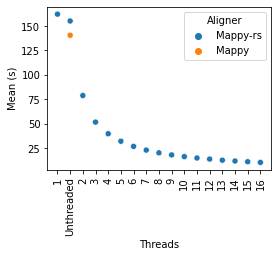

In [104]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))
ax = sns.scatterplot(data=df, x="Threads", hue="Aligner", y="Mean (s)", ax=ax)
ax.tick_params(axis="x", rotation=90)

## Calculate mean time per read

In [105]:
df["Per read (ms)"] = df["Mean (s)"] / 15704 * 1000

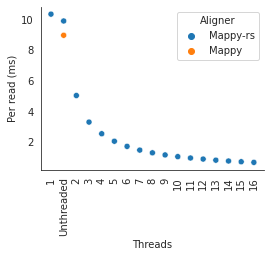

In [106]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))
    ax = sns.scatterplot(data=df, x="Threads", hue="Aligner", y="Per read (ms)", ax=ax)
    ax.tick_params(axis="x", rotation=90)
    sns.despine()
    fig.savefig("mappy_rs_speed.png", dpi=300, bbox_inches="tight")

    fig.savefig(" Supplemental_Fig_S1.tiff", dpi=300, bbox_inches="tight")
    fig.savefig("mappy_rs_speed.pdf", dpi=300, bbox_inches="tight")